In [5]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

## FTA Hyperparameter Sweep

### Reading CSVs

In [41]:
data_dir = "output/"
file_prefix = "fta"

fta_dict = {}
for file in os.listdir(data_dir):
    if file.split("_")[0] != file_prefix:
        continue

    # Reading data from CSV    
    df = pd.read_csv(os.path.join(data_dir,file), skiprows=5)
    scores = np.expand_dims(np.asarray(df["Score:"]), 1)
    avg_scores = np.expand_dims(np.asarray(df["Average Score:"]), 1)
    
    # Reading FTA params from file name
    upper_limit = float(file.split('u')[1].split("_")[0])
    delta = float(file.split('d')[1].split("_")[0])
    num_tiles = round(2*upper_limit/delta)

    # Populating fta dict
    if upper_limit not in fta_dict.keys():
        fta_dict[upper_limit] = {}
    if num_tiles not in fta_dict[upper_limit].keys():
        fta_dict[upper_limit][num_tiles] = {"scores": scores,
                                            "avg_scores": avg_scores,
                                            "runs": 1}
    else:
        if scores.shape[0] != fta_dict[upper_limit][num_tiles]["scores"].shape[0]:
            continue
        fta_dict[upper_limit][num_tiles]["scores"] = \
            np.concatenate((fta_dict[upper_limit][num_tiles]["scores"], scores), axis = 1) 
        fta_dict[upper_limit][num_tiles]["avg_scores"] = \
            np.concatenate((fta_dict[upper_limit][num_tiles]["avg_scores"], avg_scores), axis = 1)
        fta_dict[upper_limit][num_tiles]["runs"] = fta_dict[upper_limit][num_tiles]["runs"] + 1

# pprint(fta_dict, depth =2, indent = 2)
for upper_limit in sorted(fta_dict.keys()):
    print(f"{upper_limit}:")
    string = ""
    for num_tiles in sorted(fta_dict[upper_limit].keys()):
        string  = string + f"\t{num_tiles}: runs: {fta_dict[upper_limit][num_tiles]['runs']}"
    print(string)


0.05:
	10: runs: 5	11: runs: 5	12: runs: 5	13: runs: 5	14: runs: 5	15: runs: 5
0.1:
	10: runs: 5	11: runs: 5	12: runs: 5	13: runs: 5	14: runs: 5	15: runs: 5
0.25:
	10: runs: 5	11: runs: 5	12: runs: 5	13: runs: 5	14: runs: 5	15: runs: 5
0.5:
	10: runs: 5	11: runs: 5	12: runs: 5	13: runs: 5	14: runs: 5	15: runs: 5
1.0:
	10: runs: 5	11: runs: 5	12: runs: 5	13: runs: 5	14: runs: 5	15: runs: 5
2.0:
	10: runs: 5	11: runs: 5	12: runs: 5	13: runs: 5	14: runs: 5	15: runs: 5


### Plotting

In [42]:
def smooth_data(scores, smoothness=20):
    if smoothness is None:
        return scores

    smooth_scores = np.zeros((scores.shape[0] - smoothness, scores.shape[1]))
    for i in range(scores.shape[1]):
        for j in range(smooth_scores.shape[0]):
            smooth_scores[j,i] = np.mean(scores[j : j + smoothness, i])

    return smooth_scores


def plot(all_scores, plot_settings, save_file, smoothness=20):
    x = np.arange(len(all_scores[0]) - smoothness)
    for i, scores in enumerate(all_scores):
        smooth_scores = smooth_data(scores, smoothness=smoothness)
        plt.plot(x, smooth_scores, label=plot_settings[i]["label"])
    plt.legend(loc="upper left")
    # plt.savefig(save_file)

def get_mean_ste(scores):
    scores_mean = np.mean(scores, axis=1)
    scores_ste = np.std(scores, axis=1) / np.sqrt(scores.shape[1])
    return scores_mean, scores_ste
    

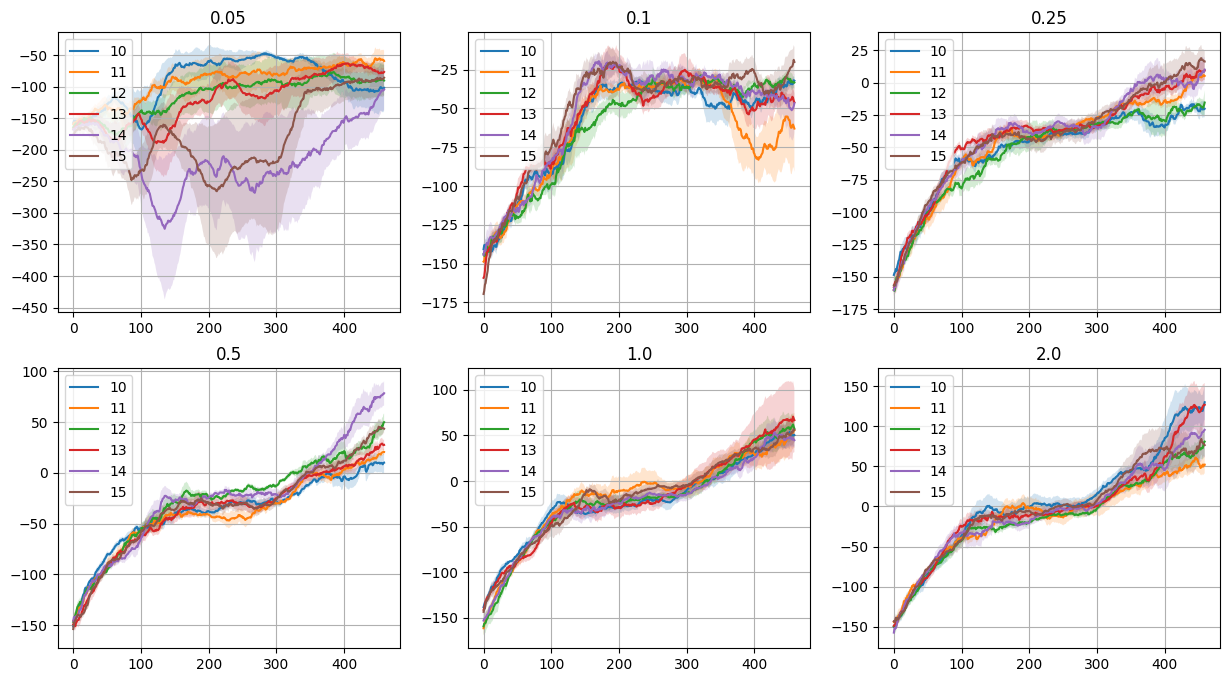

In [44]:
plots_in_onerow = 3
fig, axs = plt.subplots(math.ceil(len(fta_dict.keys())/plots_in_onerow), plots_in_onerow, figsize=(15, 8))
which_scores = "scores" # "avg_scores" or "scores"
smoothness = 40 # int or None

for i, upper_limit in enumerate(sorted(fta_dict.keys())):
    for num_tiles in sorted(fta_dict[upper_limit].keys()):
        runs = fta_dict[upper_limit][num_tiles]["runs"]
        if runs < 5:
            continue
        
        # smoothing scores for each run and calculating mean and ste
        smooth_scores = smooth_data(fta_dict[upper_limit][num_tiles][which_scores], smoothness)
        scores_mean, scores_ste = get_mean_ste(smooth_scores)
        x = np.arange(len(scores_mean))

        r, c = int(i/plots_in_onerow), i%plots_in_onerow
        axs[r, c].plot(x, scores_mean, label=num_tiles)
        axs[r, c].fill_between(x, scores_mean+scores_ste, scores_mean-scores_ste, alpha=0.2)
    axs[r, c].legend(loc="upper left")
    axs[r, c].set_title(str(upper_limit))
    axs[r, c].grid()
